# Part 3 - Pinecone VectorDB and RAG


##### Imports

In [78]:
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
from pinecone import Pinecone, ServerlessSpec
import os
from tqdm import tqdm
import cohere
import numpy as np
import warnings
from IPython.display import display
import matplotlib.pyplot as plt
import time
warnings.filterwarnings("ignore")

##### APIs

In [74]:
from api_keys import PINECONE_API_KEY, COHERE_API_KEY

##### LLM

In [76]:
EMBEDDING_MODEL = 'all-MiniLM-L6-v2'
model = SentenceTransformer(EMBEDDING_MODEL)
co = cohere.Client(api_key=COHERE_API_KEY)

### 1 - Dataset

We selected the SQuAD dataset for our project. The dataset is a collection of question-answer pairs, where the questions are based on a set of Wikipedia articles. 

We will show the original LLM preforms poorly in some cases, which can be improved by using RAG.

In [4]:
DATASET_NAME = 'squad'

print("Loading and embedding the dataset")
dataset = load_dataset(DATASET_NAME)
print("Done!")

Loading and embedding the dataset
Done!


##### Preprocessing

In [6]:
train_data = dataset['train']
val_data = dataset['validation']

# show the columns:
train_data

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 87599
})

In [7]:
# collect all the documents from the corpus:
documents = train_data['context'].copy()
documents.extend(val_data['context'])

# remove identical documents (multiple questions can refer to the same context):
documents = list(set(documents))
print(f"Number of documents: {len(documents)}")

# embed the documents
document_embeddings = model.encode(documents)
print(f"Number of document embeddings: {len(document_embeddings)}")

Number of documents: 20958
Number of document embeddings: 20958


In [9]:
emb_shape = document_embeddings.shape
print(f"The embeddings shape: {emb_shape}")

The embeddings shape: (20958, 384)


##### Chunking

Lets explore the lengths of the documents in the dataset:

In [73]:
# max length of document:
max_len = max([len(doc.split()) for doc in documents])
print(f"The maximum length of a document: {max_len} words")
print(f"Average length of a document: {np.mean([len(doc.split()) for doc in documents])} words")

The maximum length of a document: 653 words
Average length of a document: 117.24706555969081 words


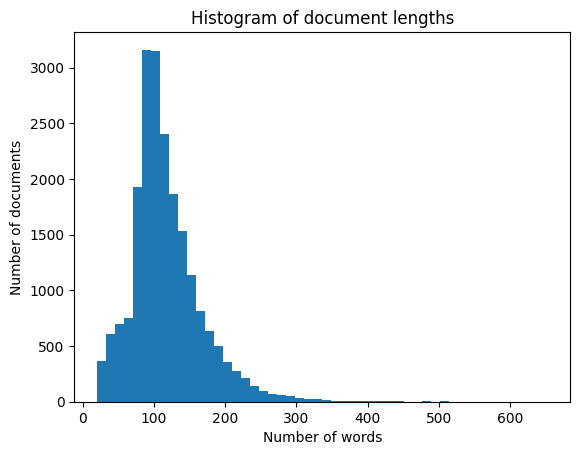

In [60]:
plt.hist([len(doc.split()) for doc in documents], bins=50)
plt.xlabel("Number of words")
plt.ylabel("Number of documents")
plt.title("Histogram of document lengths")
plt.show()

These are for the most part very short documents (for reference, a paragraph is usually 100-200 words), with the largest outliers being ~600 words at most. Because of this, we thought chunking might cause more loss of information than gain in noise reduction.
Furthermore, we checked that the largest document and query in the dataset are well within the limits of the model, so we will not encounter any issues with the model's input size.

Therefore, we chose not to chunk the documents, as answered in the forum that we could.

### 2 - Pinecone Vector Database

In [10]:
from pinecone import Pinecone, ServerlessSpec

def create_pinecone_index(
        index_name: str,
        dimension: int,
        metric: str = 'cosine', # assume standard cosine similarity
):
    """
    Create a pinecone index if it does not exist
    Args:
        index_name: The name of the index
        dimension: The dimension of the index
        metric: The metric to use for the index
    Returns:
        Pinecone: A pinecone object which can later be used for upserting vectors and connecting to VectorDBs
    """

    print("Creating a Pinecone index...")
    pc = Pinecone(api_key=PINECONE_API_KEY)
    existing_indexes = [index_info["name"] for index_info in pc.list_indexes()]

    if index_name not in existing_indexes:
        pc.create_index(
            name=index_name,
            dimension=dimension,
            metric=metric,
            spec=ServerlessSpec(
                cloud="aws",
                region="us-east-1"
            )
        )
    print("Done!")
    return pc

In [11]:
INDEX_NAME = 'squad-index'

# Create the vector database
pc = create_pinecone_index(INDEX_NAME, emb_shape[1])

Creating a Pinecone index...
Done!


In [12]:
def upsert_vectors(
        index: Pinecone,
        embeddings: np.ndarray,
        batch_size: int = 128
):
    """
    Upsert vectors to a pinecone index
    Args:
        index: The pinecone index object
        embeddings: The embeddings to upsert
        batch_size: The batch size to use for upserting
    Returns:
        An updated pinecone index
    """
    print("Upserting the embeddings to the Pinecone index...")
    shape = embeddings.shape
    
    ids = [str(i) for i in range(shape[0])]
    
    # create list of (id, vector) tuples to be upserted
    to_upsert = list(zip(ids, embeddings))

    for i in tqdm(range(0, shape[0], batch_size)):
        i_end = min(i + batch_size, shape[0])
        index.upsert(vectors=to_upsert[i:i_end])
    return index


In [14]:
# Upsert the embeddings to the Pinecone index
index = pc.Index(INDEX_NAME)
index_upserted = upsert_vectors(index, document_embeddings, batch_size=128)

Upserting the embeddings to the Pinecone index...


100%|██████████| 164/164 [15:20<00:00,  5.61s/it] 


In [15]:
index.describe_index_stats()

{'dimension': 384,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 20958}},
 'total_vector_count': 20958}

### 3 - LLM Without Retrieval

Try to find a few badly preforming examples with similarity to the real answer:

In [79]:
def cosine_similarity(a, b):
    return np.dot(a, b.T) / (np.linalg.norm(a) * np.linalg.norm(b))

In [ ]:
results = {}

for entry in [train_data[i] for i in range(20)]:
    q = entry['question']
    answer = entry['answers']['text'][0]
    response = co.chat(model='command-r-plus', message=q).text

    answer_emb = model.encode(answer)
    response_emb = model.encode(response)
    similarity = cosine_similarity(answer_emb, response_emb)

    results[(q, answer, response)] = similarity
    # print(similarity)

Demonstrate a few examples where the LLM preforms poorly:

In [52]:
worst_answers = sorted(results.items(), key=lambda x: x[1])[:3]

for (q, answer, response), similarity in worst_answers:
    print("#" * 50)
    print(f"Question: {q}")
    print(f"Correct Answer: {answer}")
    response = response.replace("\n\n", "\n")
    print(f"Response: {response}")

##################################################
Question: The College of Science began to offer civil engineering courses beginning at what time at Notre Dame?
Correct Answer: the 1870s
Response: The College of Science at the University of Notre Dame began offering civil engineering courses in the fall of 2019. This expansion of the college's curriculum was part of a broader effort to enhance the university's engineering programs and provide students with a more diverse range of educational opportunities.
The addition of civil engineering to the College of Science reflected the growing demand for professionals in this field and Notre Dame's commitment to meeting the evolving needs of its students and the job market. By offering courses in areas such as structural analysis, environmental engineering, and construction management, the college provided a solid foundation for those aspiring to pursue careers in civil engineering or related disciplines.
Notre Dame's decision to include ci

**Notice that in at least these 3 examples, out of 20 we ran, the LLM without additional context is wrong. We will look back at these examples after we add the RAG model.**

### 4 - RAG Pipeline

In [22]:
def augment_prompt(
        query: str,
        model: SentenceTransformer = SentenceTransformer('all-MiniLM-L6-v2'),
        index=None,
        k: int = 3
) -> str:
    """
    Augment the prompt with the top k results from the knowledge base
    Args:
        query: The query to augment
        model: The sentence transformer model
        index: The vectorstore object
        k: The number of results to include in the prompt
    Returns:
        str: The augmented prompt
    """
    results = [float(val) for val in list(model.encode(query))]
    
    # get top k results from knowledge base:
    query_results = index.query(
        vector=results,
        top_k=k,
        include_values=True,
        include_metadata=True
    )['matches']

    # find the texts that correspond to the top k results:
    id_matches = [match['id'] for match in query_results]
    text_matches = [documents[int(match_id)] for match_id in id_matches]
    source_knowledge = "\n\n".join(text_matches)
    
    # feed into an augmented prompt:
    augmented_prompt = f"""Using the contexts below, answer the query.
    Contexts:
    {source_knowledge}
    If the answer is not included in the source knowledge - say that you don't know.
    Query: {query}"""
    
    return augmented_prompt, source_knowledge

In [55]:
for (q, answer, prev_response), _ in worst_answers:
    augmented_prompt, source_knowledge = augment_prompt(q, model=model, index=index)
    response = co.chat(model='command-r-plus', message=augmented_prompt).text
    response = response.replace("\n\n", "\n")

    print("#" * 50)
    print(f"Question: {q}")
    print(f"Correct Answer: {answer}")
    print(f"New Response: {response}")
    print(f"Source Knowledge: {source_knowledge[:500]}...")

##################################################
Question: The College of Science began to offer civil engineering courses beginning at what time at Notre Dame?
Correct Answer: the 1870s
New Response: The College of Science at Notre Dame began offering early courses in civil and mechanical engineering in the 1870s.
Source Knowledge: The College of Engineering was established in 1920, however, early courses in civil and mechanical engineering were a part of the College of Science since the 1870s. Today the college, housed in the Fitzpatrick, Cushing, and Stinson-Remick Halls of Engineering, includes five departments of study – aerospace and mechanical engineering, chemical and biomolecular engineering, civil engineering and geological sciences, computer science and engineering, and electrical engineering – with eight B.S. de...
##################################################
Question: How many departments are within the Stinson-Remick Hall of Engineering?
Correct Answer: five
New R

**Successfully, in all examples the RAG model was able to provide the correct answer to questions that the LLM model failed to answer correctly.**

### 5 - Insights

In [92]:
time_llm = []
time_rag = []

similarity_llm = []
similarity_rag = []

### Evaluate the first 50 entries in the training data anecdotally:
for entry in tqdm([train_data[i] for i in range(50)]):
    q = entry['question']
    answer = entry['answers']['text'][0]

    start = time.time()
    llm_response = co.chat(model='command-r-plus', message=q).text
    time_llm.append(time.time() - start)

    start = time.time()
    augmented_prompt, source_knowledge = augment_prompt(q, model=model, index=index)
    rag_response = co.chat(model='command-r-plus', message=augmented_prompt).text
    time_rag.append(time.time() - start)

    answer_emb = model.encode(answer)
    llm_response_emb = model.encode(llm_response)
    rag_response_emb = model.encode(rag_response)

    similarity_llm.append(cosine_similarity(answer_emb, llm_response_emb))
    similarity_rag.append(cosine_similarity(answer_emb, rag_response_emb))

100%|██████████| 50/50 [03:43<00:00,  4.47s/it]


Text(0, 0.5, 'Mean Run-Time (s)')

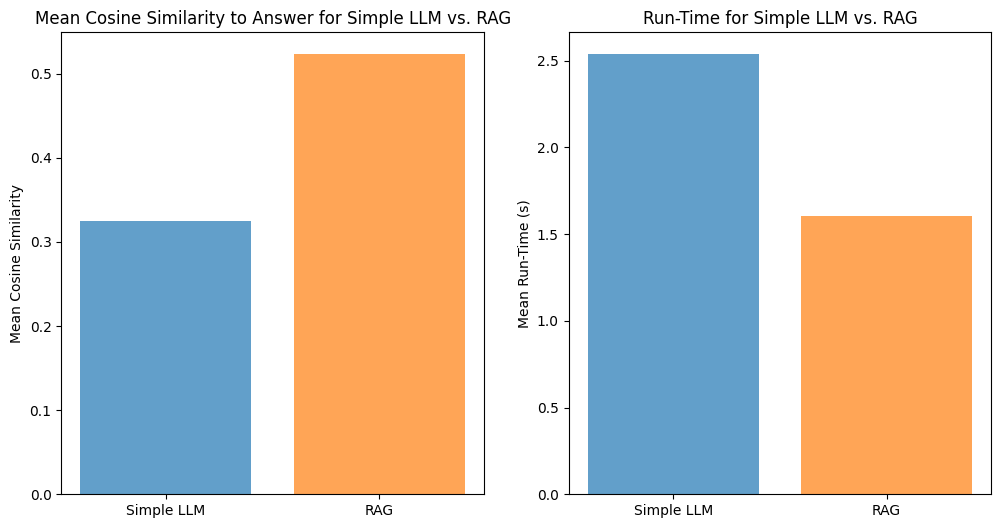

In [123]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].title.set_text("Mean Cosine Similarity to Answer for Simple LLM vs. RAG")
ax[0].bar(["Simple LLM", "RAG"], [np.mean(similarity_llm), np.mean(similarity_rag)], color=['C0', 'C1'], alpha=0.7)
ax[0].set_ylabel("Mean Cosine Similarity")

ax[1].title.set_text("Run-Time for Simple LLM vs. RAG")
ax[1].bar(["Simple LLM", "RAG"], [np.mean(time_llm), np.mean(time_rag)], color=['C0', 'C1'], alpha=0.7)
ax[1].set_ylabel("Mean Run-Time (s)")


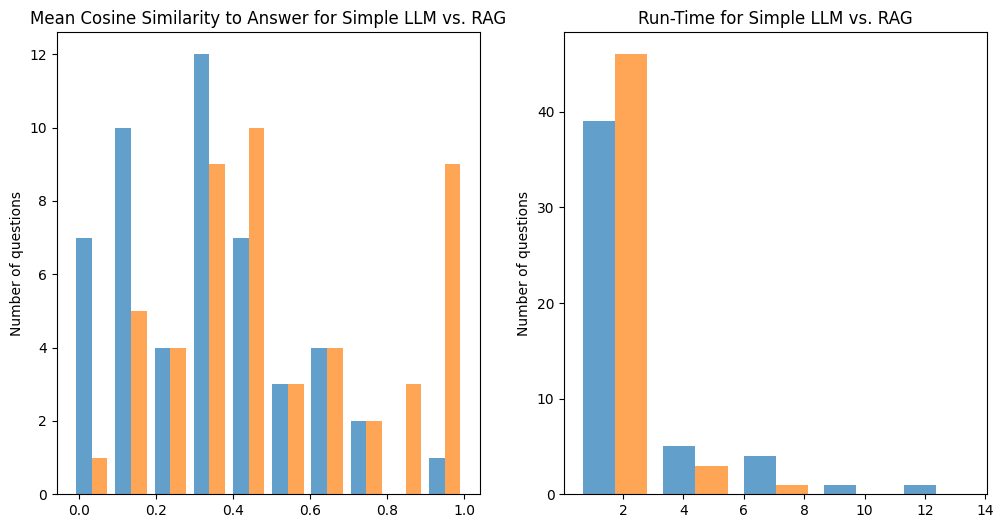

In [117]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].title.set_text("Mean Cosine Similarity to Answer for Simple LLM vs. RAG")
ax[0].hist([similarity_llm, similarity_rag], bins=10, label=["Simple LLM", "RAG"], alpha=0.7)
ax[0].set_ylabel("Number of questions")

ax[1].title.set_text("Run-Time for Simple LLM vs. RAG")
ax[1].hist([time_llm, time_rag], bins=5, label=["Simple LLM", "RAG"], alpha=0.7)
ax[1].set_ylabel("Number of questions")
plt.show()
